<a href="https://colab.research.google.com/github/hernanmorales-navarrete/Image_Processing/blob/main/Image_analysis_tutorial_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image processing with Python II

- This is a tutorial on the basics of image analysis with Python

## 1. Importing Modules & Packages

- Import the necesary packages

In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.color import rgb2gray
from skimage.util import img_as_float32
from skimage.filters import threshold_otsu
from skimage.transform import resize

## 2. Loading Image Data and vizualize

*   Load all images in the /data2 folder (not one by one, but efficiently using a loop or list comprehension).
*   Transform the GT to binary mask, if necessary
*   Visualize the images using subplots, arranging them in X rows and 2 columns (left column for noisy images and right column for the corresponding ground truth (GT) images).
*   Ensure the color bar range is the same for both columns, i.e., use the same color scale for all images.

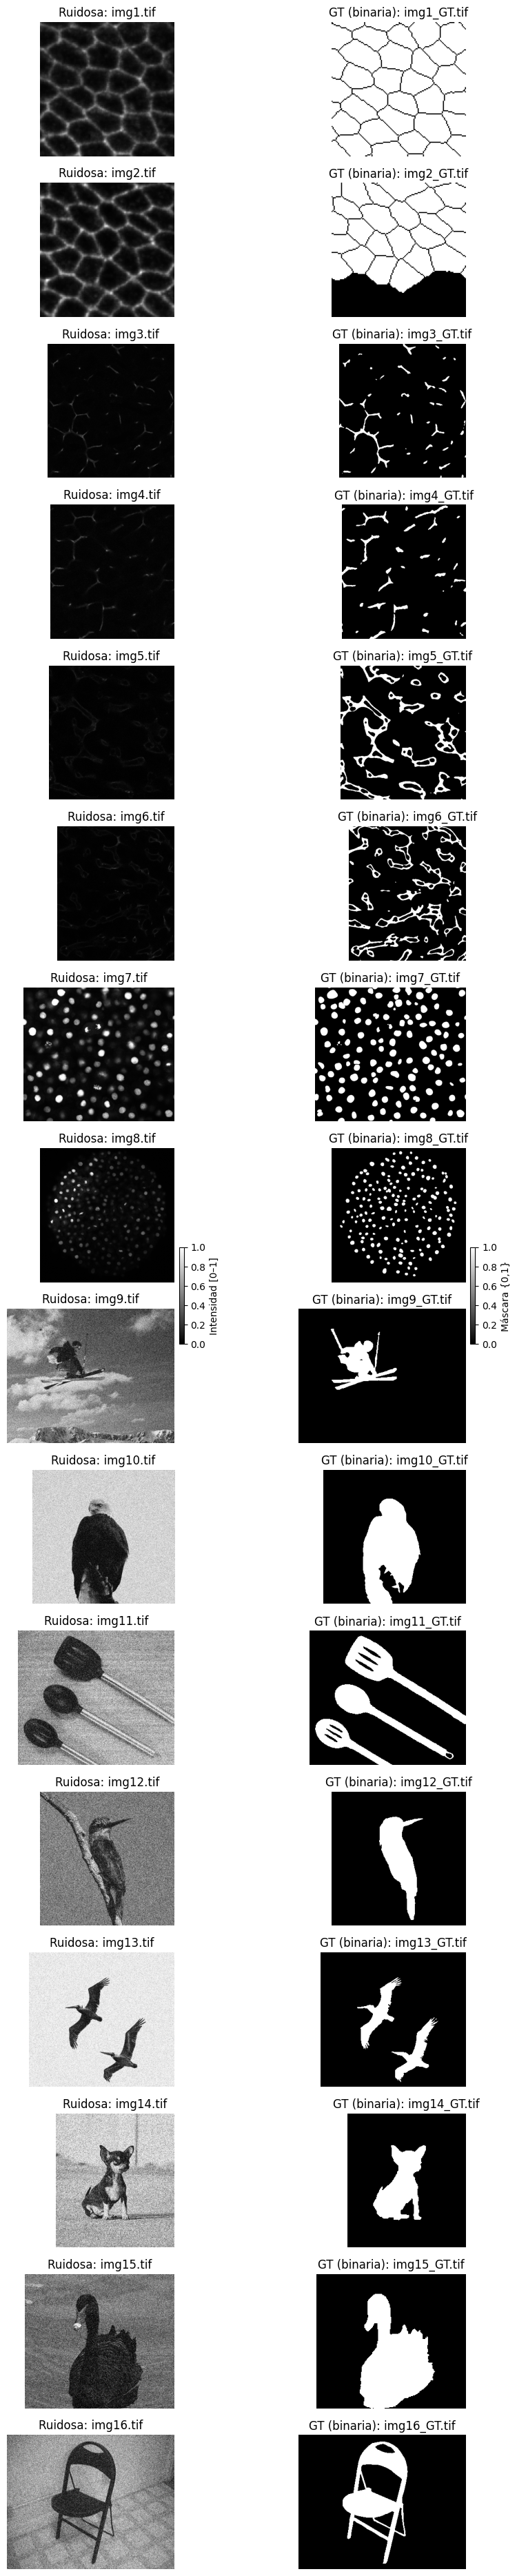

In [2]:
data_folder = "data2"

# --- helpers ---
def base_name(f):
    """Quita el sufijo _GT/-GT y la extensión para emparejar."""
    name, _ = os.path.splitext(f)
    return re.sub(r'[_-]GT$', '', name, flags=re.IGNORECASE)

def natural_key(s):
    """Orden natural: img2 antes que img10."""
    return [int(t) if t.isdigit() else t.lower()
            for t in re.split(r'(\d+)', s)]

def load_gray_float01(path):
    """
    Carga cualquier imagen (RGB/GRIS, uint8/uint16/float) y la devuelve
    como float32 en [0,1] (si era RGB, la pasa a gris).
    """
    im = skio.imread(path)
    if im.ndim == 3 and im.shape[-1] >= 3:
        im = rgb2gray(im)             # -> float [0,1]
        return im.astype(np.float32)
    return img_as_float32(im)         # normaliza bit-depth a [0,1]

def gt_to_binary_mask(path):
    """
    Carga la GT y la convierte a máscara binaria {0,1} de forma robusta.
    - Si ya está en 0/1 ó 0/255 -> normaliza directo.
    - Si es gris -> umbraliza con Otsu.
    - Si la máscara resultante tiene mayoría de 1s (blanco), se deja así.
      Si por convención quieres '1 = objeto' y eso fuera la minoría,
      puedes invertir (aquí no invertimos automáticamente).
    """
    g = load_gray_float01(path)           # float [0,1]
    if np.unique(g).size <= 3:
        m = (g > 0.5).astype(np.uint8)    # normaliza {0,1}
    else:
        thr = threshold_otsu(g)
        m = (g >= thr).astype(np.uint8)
    return m

# --- listar y separar archivos ---
files = [f for f in os.listdir(data_folder)
         if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

noisy_map, gt_map = {}, {}
for f in files:
    if re.search(r'[_-]GT\.', f, re.IGNORECASE):
        gt_map[base_name(f)] = f
    else:
        noisy_map[base_name(f)] = f

keys = sorted(set(noisy_map) & set(gt_map), key=natural_key)
if not keys:
    raise RuntimeError("No se encontraron pares noisy/GT con sufijo _GT/-GT.")

# --- cargar pares (alineando tamaños si difieren) ---
noisy_images, gt_images, noisy_names, gt_names = [], [], [], []
for k in keys:
    n = load_gray_float01(os.path.join(data_folder, noisy_map[k]))   # float [0,1]
    g = gt_to_binary_mask(os.path.join(data_folder, gt_map[k]))      # {0,1}

    # asegurar mismo tamaño por par (importante para métricas)
    if n.shape != g.shape:
        g = resize(g.astype(np.uint8), n.shape,
                   order=0,               # vecino más cercano -> mantiene binariedad
                   anti_aliasing=False,
                   preserve_range=True).astype(np.uint8)

    noisy_images.append(n)
    gt_images.append(g)
    noisy_names.append(noisy_map[k])
    gt_names.append(gt_map[k])

# --- visualización: misma escala por columna ---
rows = len(keys)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, 3*rows))
if rows == 1:
    axes = np.array([axes])

for i in range(rows):
    # izquierda: NOISY en [0,1]
    axes[i, 0].imshow(noisy_images[i], cmap='gray', vmin=0, vmax=1)
    axes[i, 0].set_title(f'Ruidosa: {noisy_names[i]}')
    axes[i, 0].axis('off')

    # derecha: GT binaria {0,1}
    axes[i, 1].imshow(gt_images[i], cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f'GT (binaria): {gt_names[i]}')
    axes[i, 1].axis('off')

# colorbars coherentes (misma escala en cada columna)
fig.colorbar(axes[0,0].images[0], ax=axes[:,0], fraction=0.02, pad=0.02, label="Intensidad [0–1]")
fig.colorbar(axes[0,1].images[0], ax=axes[:,1], fraction=0.02, pad=0.02, label="Máscara {0,1}")


plt.show()


## 3. Image filtering

*   Transform RGB images to gray scale, when necessary.
*   Install and use the high-quality denoising method BM3D (Block-Matching and 3D Filtering): https://pypi.org/project/bm3d/.
*   Use Gaussing bluring for denoising too.
*   Use widgets for the interactive selection of the parameters and select the best values for two selected images. In other words, find the parameters that blur out the noise while keeping the structures of interest.
*   Visualize the best results using subplots. For each image, display:
    - The noisy image.
    - The results of the two filtering methods.
*   Ensure the color bar range is the same for both columns, i.e., use the same color scale for all images.
*   Estimate the Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE) (https://pypi.org/project/brisque/) and print the values over the corresponding images.
*   Make a comparative plot of the BRISQUE values (i.e. boxplot) for the raw image, and the results of the two filtering methods.
*   Conclude which one is the best method for denoising in your dataset

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from bm3d import bm3d, BM3DStages
import brisque
from ipywidgets import interact, FloatSlider

def brisque_score(img01):
    """
    Calcula BRISQUE sobre una imagen gris [0,1] o RGB [0,1].
    La librería brisque espera RGB uint8; si es gris, la replicamos a 3 canales.
    """
    x = np.clip(img01, 0, 1) # asegura rango [0,1]
    u8 = (x * 255).astype(np.uint8) # BRISQUE espera uint8 0..255

    # Asegurar 3 canales RGB (BRISQUE internamente llama a rgb2gray)
    if u8.ndim == 2:  # gris (H,W) -> RGB
        u8 = np.repeat(u8[..., None], 3, axis=2) # -> (H,W,3) R=G=B
    elif u8.ndim == 3 and u8.shape[2] == 4:  # RGBA -> RGB
        u8 = u8[..., :3]
    elif u8.ndim == 3 and u8.shape[2] == 1:  # (H,W,1) -> (H,W,3)
        u8 = np.repeat(u8, 3, axis=2)

    return float(brisque.BRISQUE().score(u8))

# Filtros
def denoise_gauss(img01, sigma):
    return gaussian(img01, sigma=float(sigma), preserve_range=True)

def denoise_bm3d(img01, sigma_psd):
    return bm3d(img01, sigma_psd=float(sigma_psd), stage_arg=BM3DStages.ALL_STAGES)

# --- Selección aleatoria de 2 imágenes (una sola vez) ---
idxs = random.sample(range(len(noisy_images)), 2)
imgs  = [noisy_images[i] for i in idxs]
names = [noisy_names[i]  for i in idxs]

print(f"Imágenes seleccionadas: {names[0]} y {names[1]}")

# --- Función que renderiza dado σ ---
def render(sigma_g, sigma_b):
    rows = len(imgs)
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(12, 3.6*rows))
    if rows == 1:
        axes = np.array([axes])

    raw_scores, gauss_scores, bm3d_scores = [], [], []

    for r, (img, name) in enumerate(zip(imgs, names)):
        img_g = denoise_gauss(img, sigma_g)
        img_b = denoise_bm3d(img, sigma_b)

        s_raw = brisque_score(img)
        s_g   = brisque_score(img_g)
        s_b   = brisque_score(img_b)
        raw_scores.append(s_raw); gauss_scores.append(s_g); bm3d_scores.append(s_b)

        axs = axes[r]
        ims = [
            axs[0].imshow(img,   cmap="gray", vmin=0, vmax=1),
            axs[1].imshow(img_g, cmap="gray", vmin=0, vmax=1),
            axs[2].imshow(img_b, cmap="gray", vmin=0, vmax=1),
        ]
        titles = [
            f"Ruidosa\n{name}\nBRISQUE={s_raw:.1f}",
            f"Gauss σ={sigma_g:.2f}\nBRISQUE={s_g:.1f}",
            f"BM3D σ={sigma_b:.3f}\nBRISQUE={s_b:.1f}",
        ]
        for ax, t in zip(axs, titles):
            ax.set_title(t); ax.axis("off")

        fig.colorbar(ims[0], ax=axs, fraction=0.02, pad=0.02).set_label("Intensidad [0–1]")


    plt.show()

    # Boxplot comparativo
    data = [raw_scores, gauss_scores, bm3d_scores]
    labels = ["Raw", "Gauss", "BM3D"]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, patch_artist=True, tick_labels=labels)
    plt.ylabel("BRISQUE (↓ mejor)")
    plt.title("Comparación BRISQUE (2 imágenes aleatorias)")
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

    # Conclusión
    means = np.array([np.mean(raw_scores), np.mean(gauss_scores), np.mean(bm3d_scores)])
    winner = labels[int(np.argmin(means))]
    print(f"Promedio BRISQUE → Raw: {means[0]:.2f} | Gauss: {means[1]:.2f} | BM3D: {means[2]:.2f}")
    print(f"➤ Método ganador (promedio más bajo): {winner}")

# --- Widgets SOLO para los sigmas ---
_ = interact(render,
             sigma_g=FloatSlider(description="σ Gauss", min=0.0, max=5.0, value=1.0, step=0.1),
             sigma_b=FloatSlider(description="σ BM3D",  min=0.005, max=0.100, value=0.030, step=0.005))

Imágenes seleccionadas: img12.tif y img7.tif


interactive(children=(FloatSlider(value=1.0, description='σ Gauss', max=5.0), FloatSlider(value=0.03, descript…

## 4. Image Segmentation
*   Sgemnetd the images after denoising using: manual thresholding, automatic threholding (i.e. Otsu) and adaptative thresholding (i.e. estimated background and substract form the image, then binarize).
*   Use widgets for the interactive selection of the manual threshold and choose the best values for 2 selected images.
*   Visualize the results using subplots. For each image, display:
    - The denoised image.
    - The corresponding mask (GT).
    - The results of the three segmentation methods.
*    Calulate the accuracy, precision, recall, f1 and dice coefficient for all images and print them over them in the plot
*    Make a comparative plots of ecah metric for all the results of the segmentation methods.
*   Conclude which one is the best method for segmentation in your dataset



## 5. Morphological operations

*   Apply differnte morphological operations, i.e. closing, opening and filling holes to the best segmention images obtained in 4.
*   Visualize the best results using subplots. For each image, display:
    - The noisy image.
    - The corresponding ground truth (GT).
    - Best segmented images (from 4).
    - Segmented images after the morphological operations.
*   Calulate the accuracy, precision, recall, f1 and dice coefficient for all image segmentations and print them over them in the plot
*    Make a comparative plots of ecah metric for all the results of the morphological operations.
*   Conclude which one is the best method for your dataset